In [106]:
import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns

#import warnings
#warnings.filterwarnings('ignore')



In [52]:
# client data
df_clients =pd.read_csv('data/client_train.csv')

# invoice score
df_invoice =pd.read_csv('data/invoice_train.csv')

/var/folders/0r/8xzhnvk55wbfn1wf1m61sm5h0000gn/T/ipykernel_2921/3352888719.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoice =pd.read_csv('data/invoice_train.csv')


In [53]:
df_clients.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [54]:
df_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


## Column descriptions:

### Client Data

* Client_id: Unique id for client
* District: District where the client is
* Client_catg: Category client belongs to
* Region: Area where the client is
* Creation_date: Date client joined
* Target: fraud:1 , not fraud: 0

### Invoice Data

* Client_id: Unique id for the client
* Invoice_date: Date of the invoice
* Tarif_type: Type of tax
* Counter_number:
* Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
* Counter_code:
* Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
* Consommation_level_1: Consumption_level_1
* Consommation_level_2: Consumption_level_2
* Consommation_level_3: Consumption_level_3
* Consommation_level_4: Consumption_level_4
* Old_index: Old index
* New_index: New index
* Months_number: Month number
* Counter_type: Type of counter

 the consumption level refers to the threshold of consumption to which a certain price is attributed

In [55]:
#Y = coffee_quality["quality_score"]

# Data cleaningin and feature engineering

In [56]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [57]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [58]:
df_invoice.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [59]:
df_invoice.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476749.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476749.0,1.230587e+11,1.657267e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476749.0,1.724884e+02,1.338871e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476749.0,7.321702e+00,1.571654e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476749.0,1.003040e+00,3.083466e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476749.0,4.109795e+02,7.573080e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476749.0,1.093225e+02,1.220123e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476749.0,2.030620e+01,1.574239e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476749.0,5.292588e+01,8.754725e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476749.0,1.776700e+04,4.036693e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


In [60]:
df_joined =  pd.merge(df_clients, df_invoice, on="client_id", how="left")
#df_clients.join(df_invoice, on='client_id', how='left')

In [61]:
df_joined.head(20)

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0.0,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0.0,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0.0,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0.0,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0.0,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC
5,60,train_Client_0,11,101,31/12/1994,0.0,2017-07-17,11,1335667,0,...,9,1,314,0,0,0,15638,15952,8,ELEC
6,60,train_Client_0,11,101,31/12/1994,0.0,2018-12-07,11,1335667,0,...,9,1,541,0,0,0,15952,16493,12,ELEC
7,60,train_Client_0,11,101,31/12/1994,0.0,2019-03-19,11,1335667,0,...,9,1,585,0,0,0,16493,17078,8,ELEC
8,60,train_Client_0,11,101,31/12/1994,0.0,2011-07-22,11,1335667,0,...,9,1,1200,186,0,0,7770,9156,4,ELEC
9,60,train_Client_0,11,101,31/12/1994,0.0,2011-11-22,11,1335667,0,...,6,1,1082,0,0,0,9156,10238,4,ELEC


In [62]:
print(df_joined.client_id.nunique())
df_joined.counter_number.nunique()

135493


201893

In [63]:
df_joined.nunique()

disrict                      4
client_id               135493
client_catg                  3
region                      25
creation_date             8088
target                       2
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

In [64]:
df_joined.counter_type.unique()

array(['ELEC', 'GAZ'], dtype=object)

In [65]:
df_joined.client_catg.unique()

array([11, 12, 51])

In [66]:
df_joined.tarif_type.unique()

array([11, 40, 15, 10, 12, 14, 13, 45, 29,  9, 30,  8, 21, 42, 27, 18, 24])

In [67]:
df_joined.groupby('counter_statue').count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
counter_statue,,,,,,,,,,,,,,,,,,,,
0,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960
1,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496
2,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
3,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258
4,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706
5,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495
46,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
420,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
618,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12


In [68]:
df_joined.groupby('counter_code').count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
counter_code,,,,,,,,,,,,,,,,,,,,
0,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035
10,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744
16,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73
25,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934
40,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482
65,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74
101,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74


In [69]:
df_joined.counter_code.unique()

array([203, 207, 413,   5, 467, 202, 420, 410,  10, 483,  25, 433, 407,
       204, 214, 442, 453, 506, 450, 403, 333, 201, 102, 305, 210, 101,
       532,  40, 310, 565, 600, 307, 303, 222,  65,   0, 227, 325,  16,
       317, 367,   1])

In [70]:
df_joined.reading_remarque.unique()

array([  8,   6,   9,   7, 207, 413, 203,   5])

In [71]:
df_joined.groupby('reading_remarque').count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,counter_code,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
reading_remarque,,,,,,,,,,,,,,,,,,,,
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939
7,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661
8,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123
9,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992
203,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
207,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
413,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12


In [72]:
df_joined.counter_coefficient.unique()

array([ 1,  3,  0, 10,  4, 33, 50, 20,  2,  6, 40,  9, 30,  5, 11,  8])

In [73]:
df_joined.old_index.unique()

array([ 14302,  12294,  14624, ..., 141551, 110850,  86004])

In [74]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   disrict               int64  
 1   client_id             object 
 2   client_catg           int64  
 3   region                int64  
 4   creation_date         object 
 5   target                float64
 6   invoice_date          object 
 7   tarif_type            int64  
 8   counter_number        int64  
 9   counter_statue        object 
 10  counter_code          int64  
 11  reading_remarque      int64  
 12  counter_coefficient   int64  
 13  consommation_level_1  int64  
 14  consommation_level_2  int64  
 15  consommation_level_3  int64  
 16  consommation_level_4  int64  
 17  old_index             int64  
 18  new_index             int64  
 19  months_number         int64  
 20  counter_type          object 
dtypes: float64(1), int64(15), object(5)
memory usage: 717.3+ MB


## To Dos

* remove client_id column
* turn into dummies: client_catg, tarif_type
* change target to 0,1 - DONE
* turn creation_date, invoice_date  into datetime or something else - DONE
* feature engineering: number of counters per client. then drop client_id, counter_number
* counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove - DONE
* counter_code: either dummies or find info on steg site or drop?
* reading_remarque: clean? turn into dummies
* counter_coefficient: try both?: treat numerically and as dummies?
* rescale consommation_level1 ... _4
* drop index old and new
* rescale months_number
* turn into dummy counter_type

In [75]:
# check how many duplicated rows exist in the data frame
df_joined.duplicated().value_counts()

# there were 11 duplicatge rows, drop duplicates
df_joined.drop_duplicates(inplace=True)

In [76]:
df_joined['counter_statue'].unique()

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

In [90]:
# counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove

df_joined['counter_statue'] = df_joined['counter_statue'].map({
    '0': 0,
    0: 0, 
    1: 1,
    2 : 2,
    3: 3,
    4: 4,  
    5: 5,
    '5': 5,
    '1': 1,
    '4': 4, 
    'A': np.nan,
    618: np.nan, 
    269375: np.nan,
    46: np.nan, 
    420: np.nan,
    769: np.nan, 
    })
df_joined['counter_statue'].nunique()

6

<Axes: >

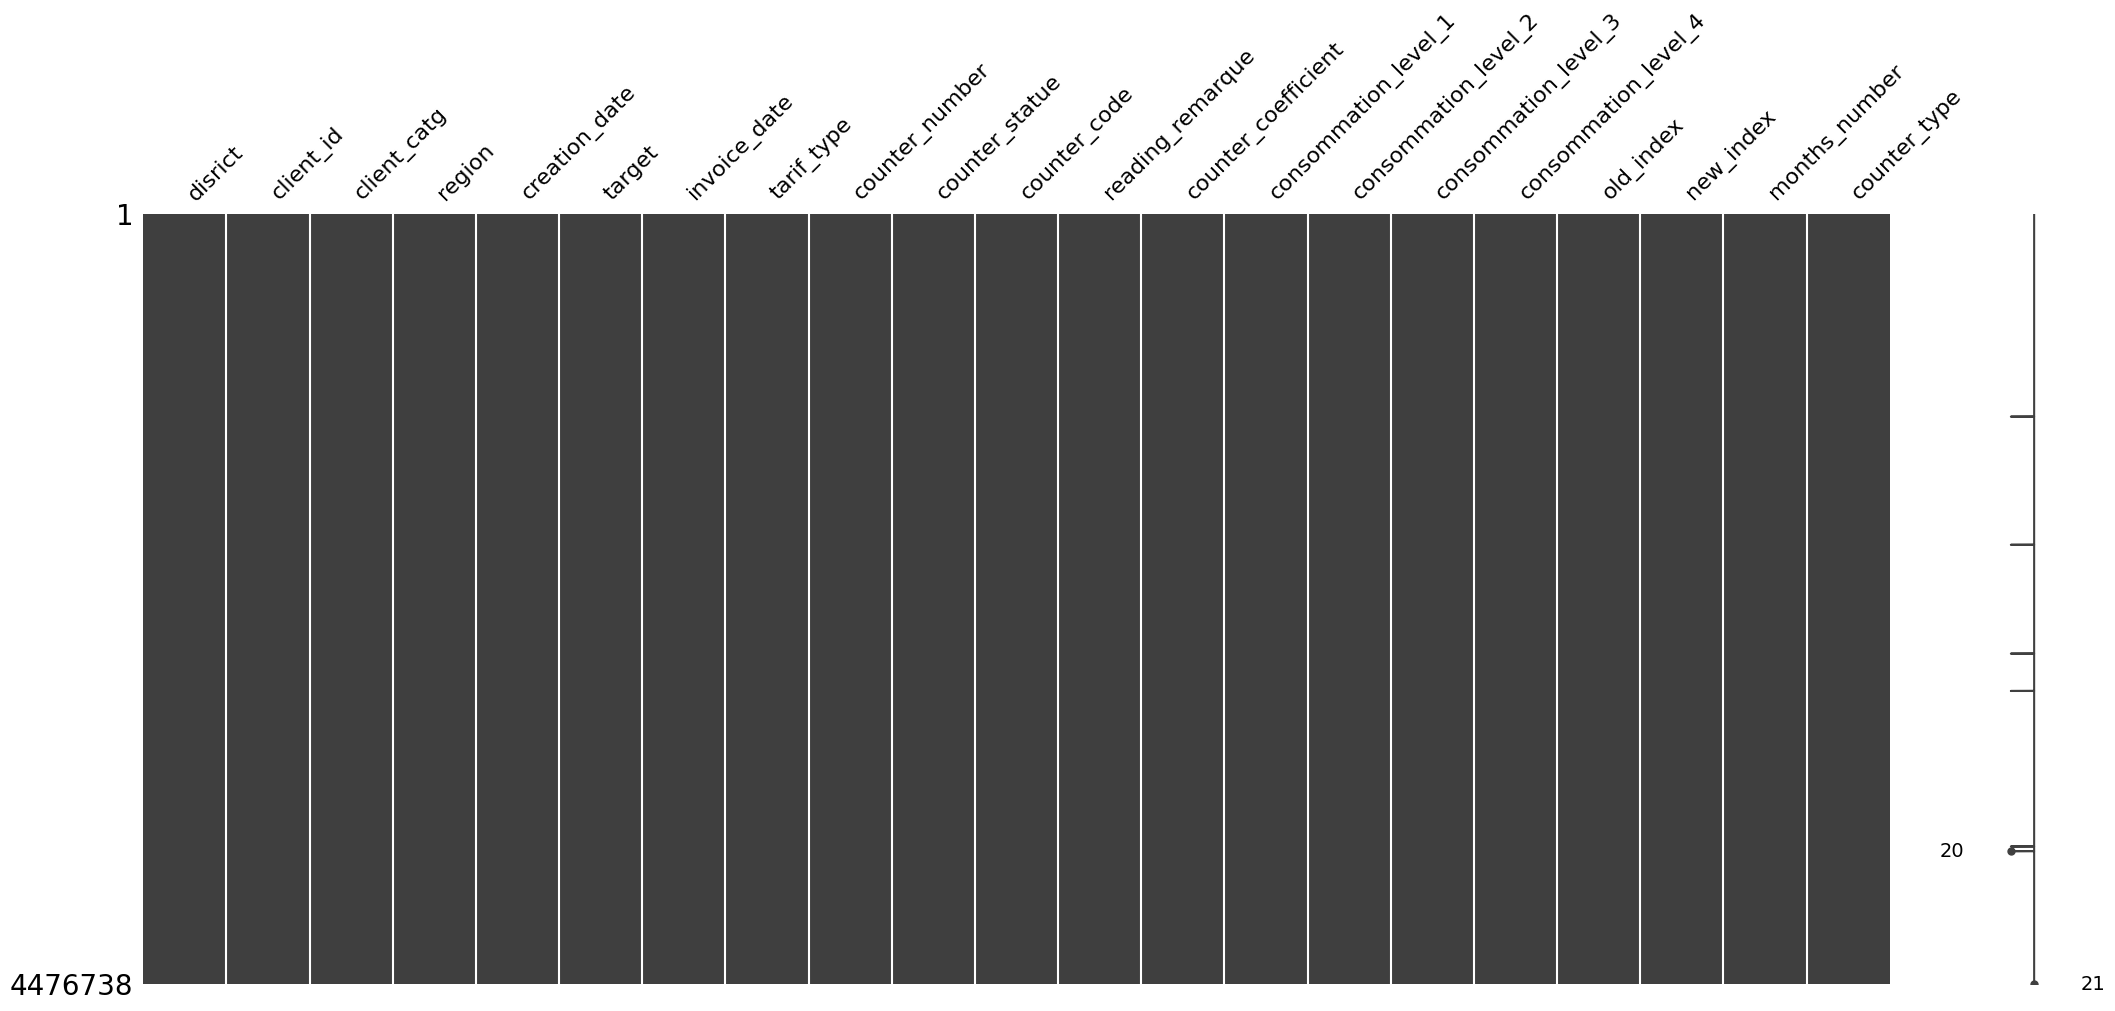

In [78]:
# check for missing distribution

#msno.matrix(df_joined)

In [94]:
# calculate fraction of data we would lose : 0.001%

print(f"numbers of rows : {df_joined.shape[0]}")
print(f"missing values in counter statue : {round(df_joined.counter_statue.isna().sum()/df_joined.shape[0]*100,4)} %")

# copy df
df_processed = df_joined.copy()
# drop NaN
df_processed.dropna(inplace=True, axis=0)


numbers of rows : 4476738
missing values in counter statue : 0.001 %


In [95]:
df_joined.isna().sum()

disrict                  0
client_id                0
client_catg              0
region                   0
creation_date            0
target                   0
invoice_date             0
tarif_type               0
counter_number           0
counter_statue          47
counter_code             0
reading_remarque         0
counter_coefficient      0
consommation_level_1     0
consommation_level_2     0
consommation_level_3     0
consommation_level_4     0
old_index                0
new_index                0
months_number            0
counter_type             0
dtype: int64

In [96]:
df_processed.isna().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
target                  0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [100]:
# change target from float to int (0,1)
df_processed.target = df_processed.target.astype(int)
df_processed.target.unique()

array([0, 1])

In [102]:
df_processed.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0,2014-03-24,11,1335667,0.0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0,2013-03-29,11,1335667,0.0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0,2015-03-23,11,1335667,0.0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0,2015-07-13,11,1335667,0.0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0,2016-11-17,11,1335667,0.0,...,9,1,572,0,0,0,15066,15638,12,ELEC


In [104]:
# turn columns invoice date and creation date to datetime

df_processed['invoice_date'] = pd.to_datetime(df_processed['invoice_date'], format='%Y-%m-%d')
df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'], format='%d/%m/%Y')

## Establishing Baseline Model

In [107]:
# pairplot

sns.pairplot(df_processed)

## Splitting data for testing 

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

NameError: name 'X' is not defined

In [ ]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_train["altitude_mean_log"] = np.log(X_train["altitude_mean_meters"])
X_train.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_train.drop(['Quakers'], axis=1, inplace=True)
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
X_train.info()

In [ ]:
altitude_low_meters_mean = X_train["altitude_low_meters"].mean()
altitude_high_meters_mean = X_train["altitude_high_meters"].mean()
altitude_mean_log_mean = X_train["altitude_mean_log"].mean()

In [ ]:
# fillna with mean.. 
X_train["altitude_low_meters"] = X_train["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_train["altitude_high_meters"] = X_train["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_train["altitude_mean_log"] = X_train["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
print(f"altitude low meters mean is {altitude_low_meters_mean}")
print(f"altitude_high_meters_mean is {altitude_high_meters_mean}")
print(f"altitude_mean_log_mean is {altitude_mean_log_mean}")

## Trainining the model

In [ ]:
## in order to exemplify how the predict will work.. we will save the y_train
X_test.to_csv("data/X_test.csv")
y_test.to_csv("data/y_test.csv")

In [ ]:
#training the model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
y_train_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)

In [ ]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_test["altitude_mean_log"] = np.log(X_test["altitude_mean_meters"])
X_test.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_test.drop(['Quakers'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
# fillna with mean.. 
X_test["altitude_low_meters"] = X_test["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_test["altitude_high_meters"] = X_test["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_test["altitude_mean_log"] = X_test["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
y_test_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)